In [73]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import umap
import random
from matplotlib.image import BboxImage
from matplotlib.transforms import Bbox, TransformedBbox
from sklearn.neighbors import KNeighborsClassifier
import pickle
from tqdm import tqdm
from utils import features_dpt_entropy, features_homology_dpt_entropy, features_vector, features_ripley_dpt_v2, preprocessing, features_avg_connection_dpt
import utils as util
import pandas as pd
import glob
from sklearn.decomposition import PCA
import simdata_generator as dataset
import os 
from sknetwork.clustering import Louvain
from sklearn.neighbors import kneighbors_graph
import scanpy_modified as scanpy
from anndata import AnnData
import scanpy as sp

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Figure 2

In [3]:
# number of datasets for each type of simulated dataset
repeat = 3000

df_cluster = []
for i in tqdm(range(repeat),position=0, leave=True):
    sim = dataset.gen_cluster(num=np.random.randint(500,1500),seed=i)
    df_cluster.append(sim)

df_traj = []
for i in tqdm(range(repeat),position=0, leave=True):
    sim = dataset.gen_trajectory(num=np.random.randint(500,1500),seed=i)
    df_traj.append(sim)
  
df_rand_cluster = []
for i in tqdm(range(repeat),position=0, leave=True):
    np.random.seed(i)
    sim, ind = dataset.gen_random(num=np.random.randint(500,1500),mode='cluster',seed=i)
    df_rand_cluster.append(sim)

df_rand_traj = []
for i in tqdm(range(repeat),position=0, leave=True):
    np.random.seed(i)
    sim, ind = dataset.gen_random(num=np.random.randint(500,1500),mode='trajectory',seed=i)
    df_rand_traj.append(sim)

all_df = df_cluster + df_traj + df_rand_cluster + df_rand_traj

if you want to save scatter plots of each dataset, run this cell! 
if not os.path.exists('scatterplots'):
    os.makedirs('scatterplots')
ct=0
for a in tqdm(all_df):
    ct += 1
    fig = plt.figure(figsize=(1.5,1.5))
    plt.scatter(a[:,0],a[:,1],s=1)
    plt.savefig('scatterplots\\{}.png'.format(ct))
    plt.close()

# generation of scores
META_SCORES = []
for df in tqdm(all_df, position=0, leave=True):
    score = util.scoring(df)
    META_SCORES.append(score)

np.save('data/simulated_metascores_12000.npy', np.array(META_SCORES))

100%|██████████| 2943/2943 [12:43:26<00:00, 15.56s/it]  


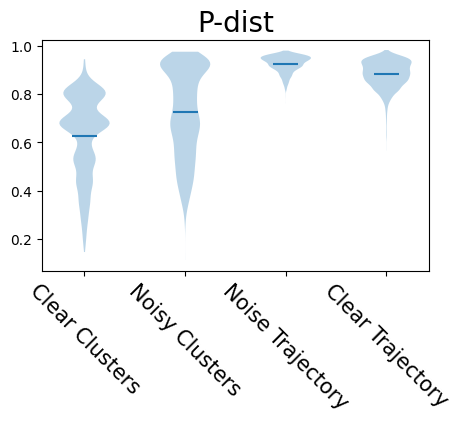

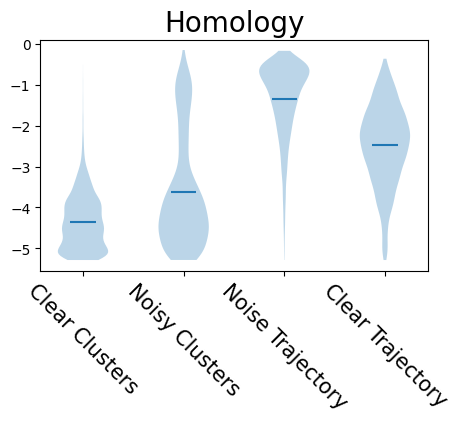

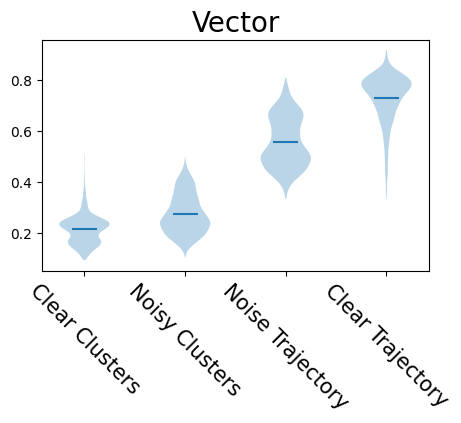

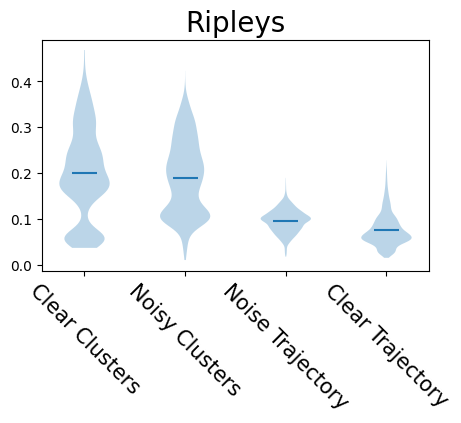

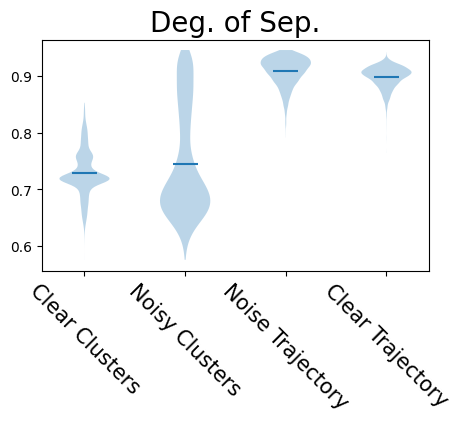

In [13]:
META_SCORES = list(np.load('data/simulated_metascores_12000.npy')) # Loading pre-computed scores for simulated datasets

clstr = META_SCORES[:repeat]
traj = META_SCORES[repeat:2*repeat]
clstr_r1 = META_SCORES[2*repeat:3*repeat]
traj_r1 = META_SCORES[3*repeat:4*repeat]

npy_sim = np.array(META_SCORES)
feature_names = ['P-dist','Homology','Vector','Ripleys','Deg. of Sep.']
for i in range(len(feature_names)):
    feat = i
    plt.figure(figsize=(5,3))
    plt.violinplot([np.array(clstr)[:,feat],
                    np.array(clstr_r1)[:,feat],
                    np.array(traj_r1)[:,feat],
                    np.array(traj)[:,feat]],
                  showmeans = True, showextrema=False)
    plt.title(feature_names[i], fontsize = 20)
    plt.xticks(fontsize=15, rotation=315)
    plt.xticks([1, 2, 3, 4], ['Clear Clusters','Noisy Clusters','Noise Trajectory','Clear Trajectory'])
    plt.show()

## Figure 3

d:\Anaconda3\envs\scVenv\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


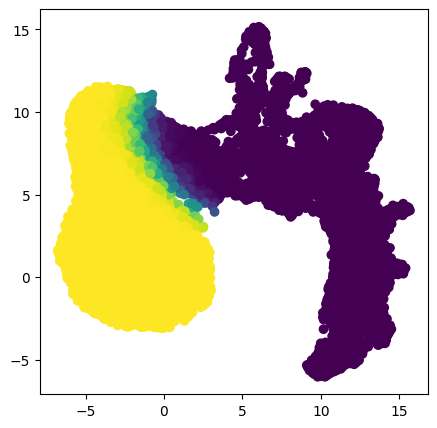

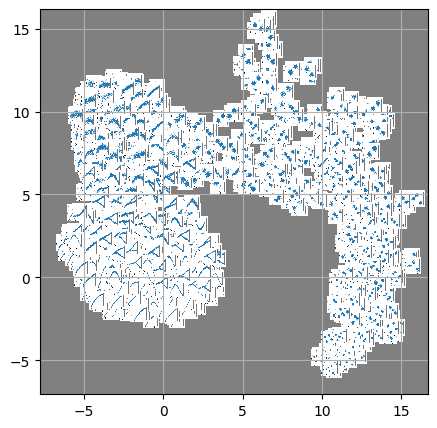

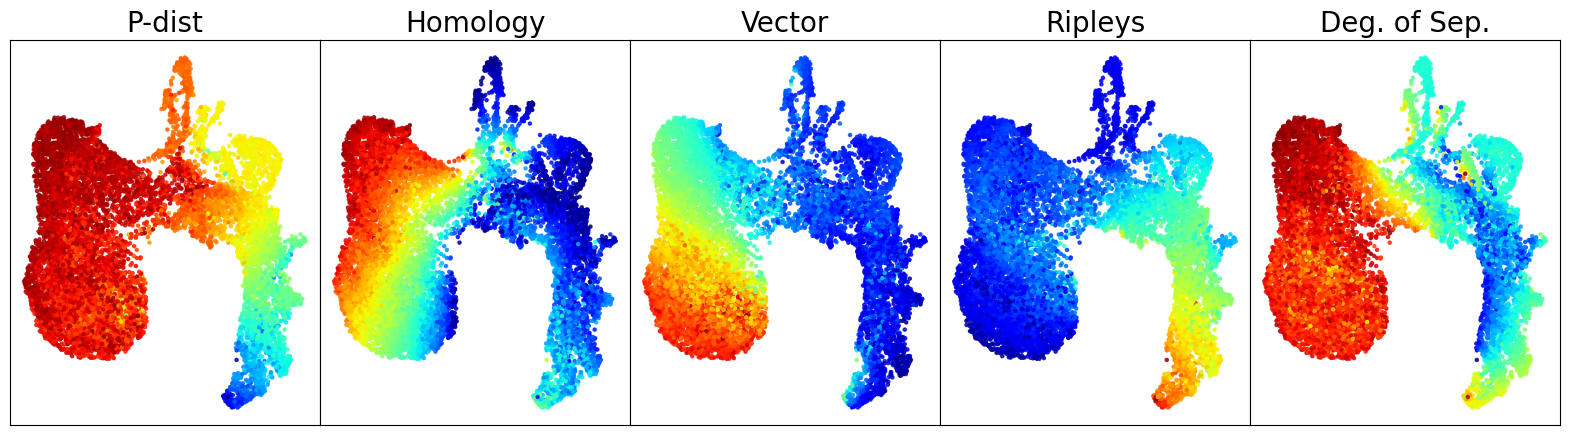

In [22]:
metric = 'euclidean'
seed = 1
n_neighbors = 50
min_dist = 0.6
figsize = 5

scaler = StandardScaler()
tmp_np = scaler.fit_transform(npy_sim)
tmp_reducer = umap.UMAP(n_neighbors=n_neighbors, n_components=2,random_state=seed,min_dist=min_dist, metric=metric)
embedding = tmp_reducer.fit_transform(tmp_np)

classes = ['Clear Clusters','Clear Trajectory','Noisy Trajectory','Noisy Clusters']
c1 = [0 for i in range(repeat)]
c2 = [1 for i in range(repeat)]
c3 = [0 for i in range(repeat)]
c4 = [1 for i in range(repeat)]

c = c1+c2+c3+c4

neigh = KNeighborsClassifier(n_neighbors=100)
neigh.fit(embedding, c)

b = neigh.predict(embedding)
p = neigh.predict_proba(embedding)[:,1]
plt.show()
plt.figure(figsize=(figsize,figsize))
plt.scatter(embedding[:,0],embedding[:,1], c = p, alpha = 1)
plt.show()

def plotImage(x, y, im):
    bb = Bbox.from_bounds(x,y,1,1)  
    bb2 = TransformedBbox(bb,ax.transData)
    bbox_image = BboxImage(bb2,
                        norm = None,
                        origin=None,
                        clip_on=False)

    bbox_image.set_data(im)
    ax.add_artist(bbox_image)
    
fig = plt.figure(figsize=(figsize,figsize))
ax = fig.add_subplot(111)
ax.grid()
ax.set_facecolor('gray')
for i in range(len(npy_sim)):
    if random.uniform(0, 1) < 0.1: 
        plotImage(embedding[i][0], embedding[i][1], plt.imread('scatterplots/{}.png'.format(i+1)))
    else:
        continue

# Set the x and y limits
border = 1
ax.set_ylim(np.min(embedding, axis =0)[1]-border,np.max(embedding, axis =0)[1]+border)
ax.set_xlim(np.min(embedding, axis =0)[0]-border,np.max(embedding, axis =0)[0]+border)
plt.show()

fig, axs = plt.subplots(1,5, figsize=(20, 5), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)

axs = axs.ravel()

for i in range(5):
    axs[i].scatter(embedding[:,0],embedding[:,1], s=5,c= npy_sim[:len(embedding),i], cmap = 'jet', alpha = 0.8)
    axs[i].set_title(feature_names[i], fontsize=20)
    axs[i].set_xticks([])
    axs[i].set_yticks([])

## Figure 4

In [23]:
def load_benchmark_data(pca_dim = 20):
    np.random.seed(42)
    files = []
    for file in glob.glob("data/benchmarkfiles/*.csv"):
        files.append(file)
    df_real = []
    for file in tqdm(files,position=0, leave=True):
        df = pd.read_csv(file, index_col=0)
        npy_array = np.array(df)
        pca = PCA(n_components=pca_dim, random_state=42)
        embedding = pca.fit_transform(npy_array)
        df_real.append(embedding)
    return df_real, files

def load_organ_data(pca_dim = 20):
    np.random.seed(42)
    files = []
    for file in glob.glob("data/scHuman/*.csv"):
        files.append(file)
    df_real = []
    files_used = []
    for file in tqdm(files,position=0, leave=True):
        df = pd.read_csv(file, index_col=0)
        npy_array = np.array(df)
        if len(npy_array) < 100:
            continue
        pca = PCA(n_components=pca_dim, random_state=42)
        embedding = pca.fit_transform(npy_array)
        df_real.append(embedding)
        files_used.append(file)
    return df_real,files_used

def load_cluster_data(pca_dim = 20):
    np.random.seed(42)
    files = []
    for file in glob.glob("data/datacuration/*.csv"):
        files.append(file)
    df_real = []
    for file in tqdm(files,position=0, leave=True):
        df = pd.read_csv(file, index_col=0)
        npy_array = np.array(df)
        pca = PCA(n_components=pca_dim, random_state=42)
        embedding = pca.fit_transform(npy_array)
        df_real.append(embedding)
    return df_real, files

df_benchmark,benchmark_files = load_benchmark_data()
df_organ,organ_files = load_organ_data()
df_cluster,cluster_files = load_cluster_data()

all_dfs = df_benchmark + df_organ + df_cluster
all_files = benchmark_files + organ_files + cluster_files

META_SCORES = []

for df in tqdm(all_dfs, position=0, leave=True):
    scores = util.scoring(df)
    META_SCORES.append(scores)
npy_real = np.stack(META_SCORES)
np.save('data/real_data_scores.npy',npy_real)

100%|██████████| 169/169 [4:13:11<00:00, 89.89s/it]   


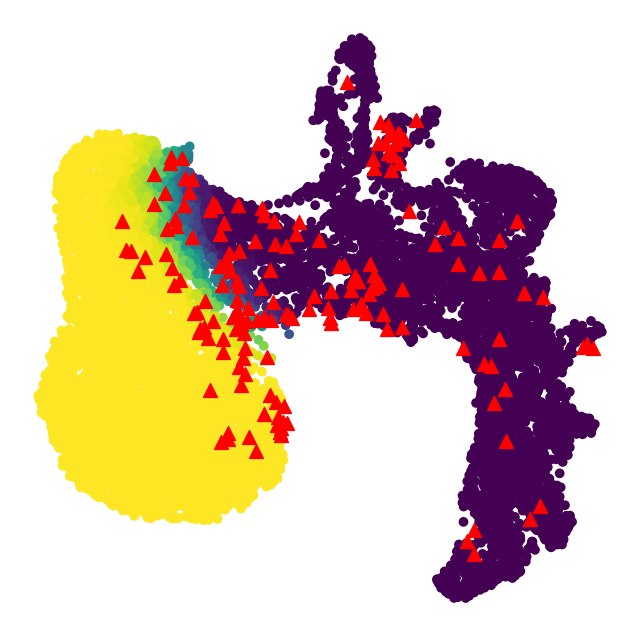

In [24]:
npy_real = np.load('data/real_data_scores.npy')
real_embs = []
for i in range(len(npy_real)):
    tmp_real = scaler.transform(npy_real[i,:].reshape(1, -1))
    d2_real_embedding = tmp_reducer.transform(tmp_real.reshape(1, -1))
    real_embs.append(d2_real_embedding)

np_real_emb = np.array(real_embs)
np_real_emb = np_real_emb.reshape((len(real_embs),2))

plt.figure(figsize=(8,8))
plt.scatter(embedding[:,0],embedding[:,1], c = p, alpha = 1)
plt.scatter(np_real_emb[:,0],np_real_emb[:,1], c = 'r', s = 100,  marker="^")
plt.axis('off')
plt.show()

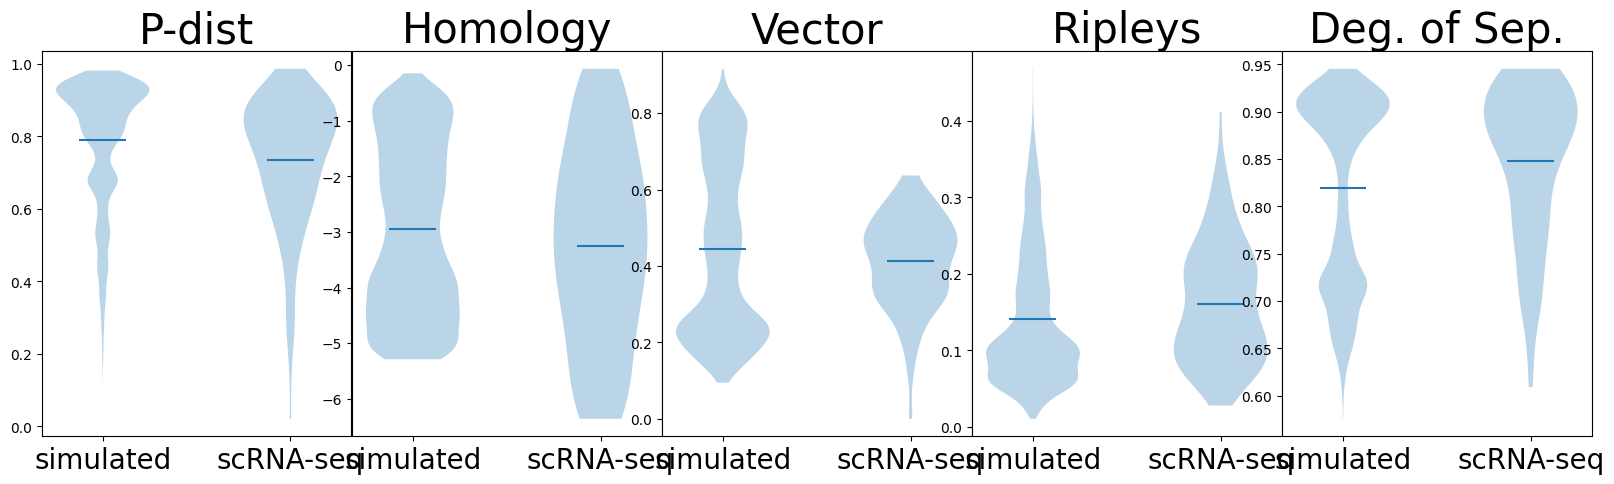

In [25]:
all_sims = np.vstack([np.array(clstr),
                    np.array(clstr_r1),
                    np.array(traj_r1),
                    np.array(traj)])
fig, axs = plt.subplots(1,5, figsize=(20, 5), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)

axs = axs.ravel()
for i in range(5):
    feat = i
    axs[i].violinplot([all_sims[:,feat],npy_real[:,feat]],
                  showmeans = True, showextrema=False)
    axs[i].set_xticks([1, 2], ['simulated','scRNA-seq'], fontsize=20)
    axs[i].set_title(feature_names[i],fontsize=30)
    

In [32]:
## table generation 
data_type = pd.read_csv('data/data_type.csv')
names = []
gold_silver = []
for name in data_type['id']:
    tmp = name.split('/')[-1]
    gold_silver.append(name.split('/')[1])
    names.append(tmp)
data_type['id'] = names

traj_type = []
for name in benchmark_files:
    a = name.split('benchmarkfiles\\')[1].split('.rds')[0]
    tt = data_type[data_type['id'] == a]['trajectory_type']
    label = np.array(tt)[0]
    traj_type.append(label)

for name in organ_files:
    traj_type.append('organ')
    
for name in cluster_files:
    traj_type.append('cluster')

COUNTS = []
for tt in np.unique(np.array(traj_type)):


    query = np.array([np_real_emb[np.array(traj_type) == tt,0],np_real_emb[np.array(traj_type) == tt,1]]).T
    prediction = neigh.predict(query)
    count_cluster=len(np.where(prediction==0)[0])
    count_traj=len(np.where(prediction==1)[0])

    COUNTS.append([count_cluster,count_traj])
fig4_c = pd.DataFrame(COUNTS,columns=['predicted clusters','predicted trajectory'],index = np.unique(np.array(traj_type)))
fig4_c

d:\Anaconda3\envs\scVenv\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
d:\Anaconda3\envs\scVenv\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

,predicted clusters,predicted trajectory
acyclic_graph,1,0
bifurcation,7,6
cluster,19,13
convergence,1,0
cycle,1,1
disconnected_graph,23,2
linear,17,22
multifurcation,6,3
organ,20,8
tree,17,2


In [33]:
fig4_c.sum()

predicted clusters      112
predicted trajectory     57
dtype: int64

## FIGURE 5

In [41]:
def louvain_labels(df):
    A = kneighbors_graph(np.array(df), 10, mode='connectivity', include_self=True)
    louvain = Louvain()
    labels = louvain.fit_transform(A)
    return labels

LABELS = []
for df in all_dfs:
    labels = louvain_labels(df)
    LABELS.append(labels)

subcluster_scores = []
files_origin = []
ct = 0
for df, labels in zip(all_dfs,LABELS):
    for unq_label in np.unique(labels):
        try:
            idx = np.where(labels == unq_label)[0]
            if len(idx) < 20:
                continue
            tp_df = df[idx,:]
            score = util.scoring(tp_df)
            subcluster_scores.append(score)
            files_origin.append(all_files[ct])
        except:
            continue
    ct += 1

npy_subcluster_scores = np.array(subcluster_scores)

tmp_sub_df = pd.DataFrame(npy_subcluster_scores)
tmp_sub_df.index = files_origin
tmp_sub_df.columns = feature_names
tmp_sub_df.to_csv('data/subcluster_scores.csv')

data/benchmarkfiles\aging-hsc-old_kowalczyk.rds.csv
data/benchmarkfiles\aging-hsc-young_kowalczyk.rds.csv
data/benchmarkfiles\blastocyst-monkey_nakamura.rds.csv
data/benchmarkfiles\bone-marrow-mesenchyme-erythrocyte-differentiation_mca.rds.csv
data/benchmarkfiles\cell-cycle_buettner.rds.csv
data/benchmarkfiles\cell-cycle_leng.rds.csv
data/benchmarkfiles\cellbench-SC1_luyitian.rds.csv
data/benchmarkfiles\cellbench-SC2_luyitian.rds.csv
data/benchmarkfiles\cellbench-SC3_luyitian.rds.csv
data/benchmarkfiles\cellbench-SC4_luyitian.rds.csv
data/benchmarkfiles\cortical-interneuron-differentiation_frazer.rds.csv
data/benchmarkfiles\dentate-gyrus-neurogenesis_hochgerner.rds.csv
data/benchmarkfiles\developing-dendritic-cells_schlitzer.rds.csv
data/benchmarkfiles\distal-lung-epithelium_treutlein.rds.csv
data/benchmarkfiles\embronic-mesenchyme-neuron-differentiation_mca.rds.csv
data/benchmarkfiles\embryonic-mesenchyme-stromal-cell-cxcl14-cxcl12-axis_mca.rds.csv
data/benchmarkfiles\epiblast-monkey_

In [42]:
subcluster_scores = pd.read_csv('data/subcluster_scores.csv',index_col = 0)
npy_subcluster_scores = subcluster_scores.values
sub_emb = []
for i in tqdm(range(len(npy_subcluster_scores))):
    tmp_real = scaler.transform(npy_subcluster_scores[i,:].reshape(1, -1))
    d2_real_embedding = tmp_reducer.transform(tmp_real.reshape(1, -1))
    sub_emb.append(d2_real_embedding)

np_sub_emb = np.array(sub_emb)
np_sub_emb = np_sub_emb.reshape((len(sub_emb),2))
#np.save('data/sub_cluster_embedding.npy',np_sub_emb)


100%|██████████| 2176/2176 [23:35<00:00,  1.54it/s]


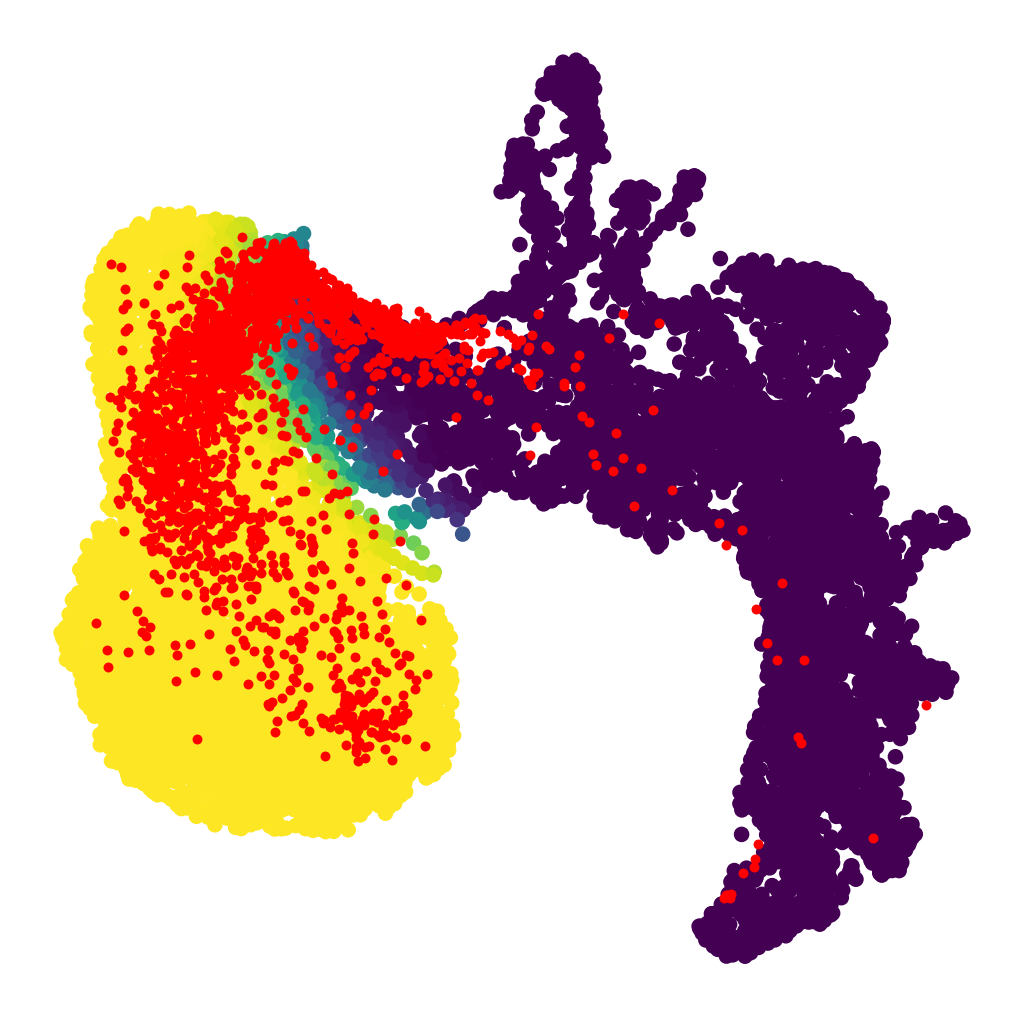

In [43]:
#np_sub_emb = np.load('data/sub_cluster_embedding.npy')
plt.figure(figsize=(8,8))
plt.scatter(embedding[:,0],embedding[:,1], c = p, alpha = 1)
plt.scatter(np_sub_emb[:,0],np_sub_emb[:,1], c = 'r', s = 12)
plt.axis('off')
plt.show()

100%|██████████| 11/11 [00:07<00:00,  1.43it/s]


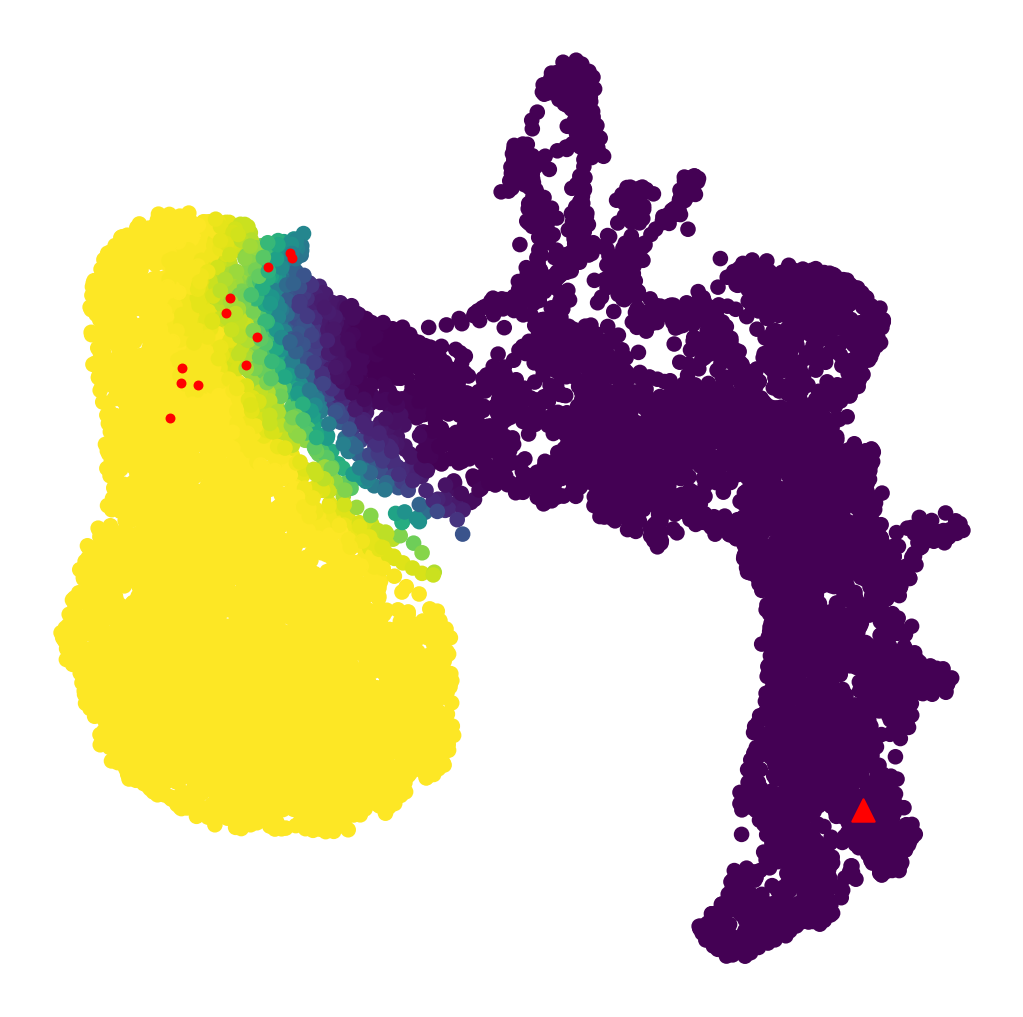

100%|██████████| 7/7 [00:04<00:00,  1.47it/s]


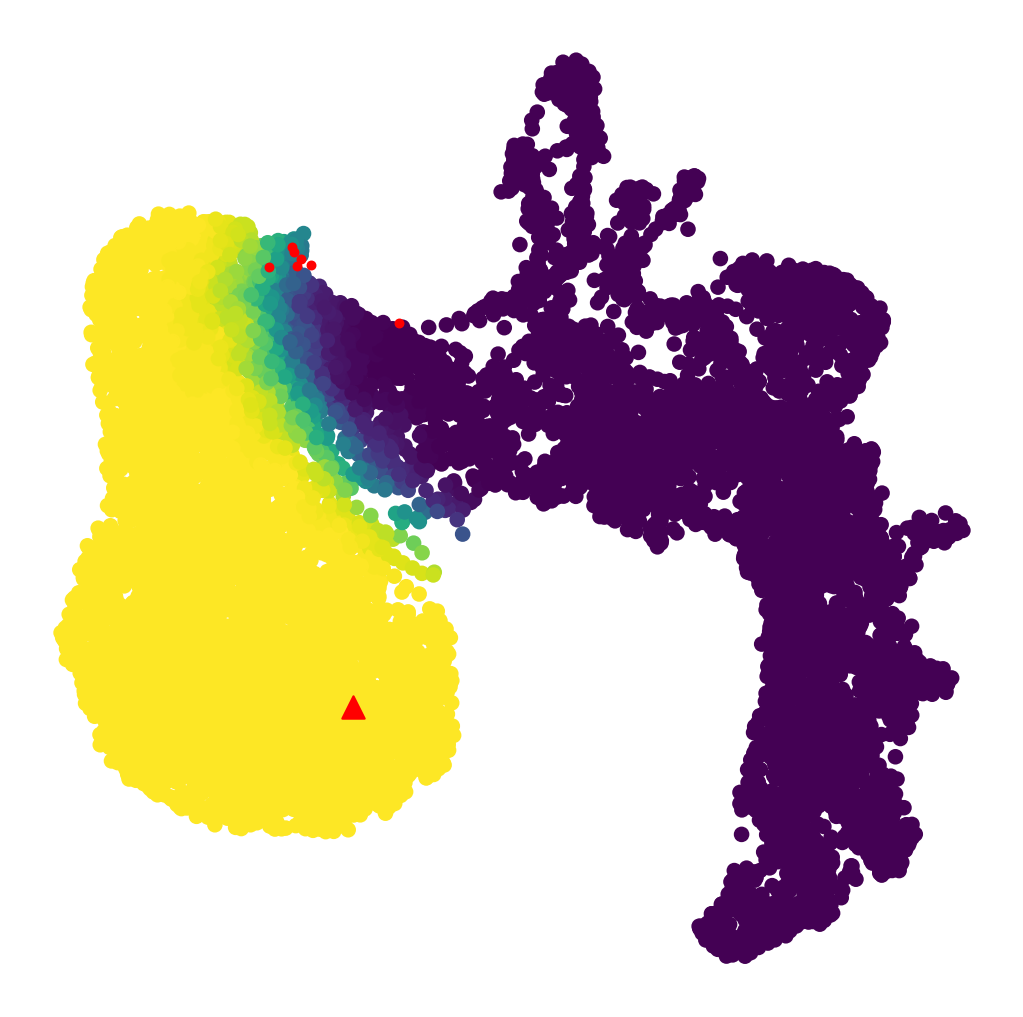

In [71]:
subnames = list(subcluster_scores.index)

nm = 'data/benchmarkfiles\mouse-cell-atlas-combination-1.rds.csv'
example_scores1 = subcluster_scores.loc[nm]
npy_subcluster_example1 = example_scores1.values
sub_emb_exp1 = []
for i in tqdm(range(len(npy_subcluster_example1))):
    tmp_real = scaler.transform(npy_subcluster_example1[i,:].reshape(1, -1))
    d2_real_embedding = tmp_reducer.transform(tmp_real.reshape(1, -1))
    sub_emb_exp1.append(d2_real_embedding)

np_sub_emb_exp1 = np.array(sub_emb_exp1)
np_sub_emb_exp1 = np_sub_emb_exp1.reshape((len(sub_emb_exp1),2))
plt.figure(figsize=(8,8))
plt.scatter(embedding[:,0],embedding[:,1], c = p, alpha = 1)
plt.scatter(np_sub_emb_exp1[:,0],np_sub_emb_exp1[:,1], c = 'r', s = 12)
idx = all_files.index(nm)
plt.scatter(np_real_emb[idx,0],np_real_emb[idx,1], c = 'r', s = 100, marker="^")

plt.axis('off')
plt.show()

nm = 'data/benchmarkfiles\embryonic-mesenchyme-stromal-cell-cxcl14-cxcl12-axis_mca.rds.csv'
example_scores1 = subcluster_scores.loc[nm]
npy_subcluster_example1 = example_scores1.values
sub_emb_exp1 = []
for i in tqdm(range(len(npy_subcluster_example1))):
    tmp_real = scaler.transform(npy_subcluster_example1[i,:].reshape(1, -1))
    d2_real_embedding = tmp_reducer.transform(tmp_real.reshape(1, -1))
    sub_emb_exp1.append(d2_real_embedding)

np_sub_emb_exp1 = np.array(sub_emb_exp1)
np_sub_emb_exp1 = np_sub_emb_exp1.reshape((len(sub_emb_exp1),2))
plt.figure(figsize=(8,8))
plt.scatter(embedding[:,0],embedding[:,1], c = p, alpha = 1)
plt.scatter(np_sub_emb_exp1[:,0],np_sub_emb_exp1[:,1], c = 'r', s = 12)
idx = all_files.index(nm)
plt.scatter(np_real_emb[idx,0],np_real_emb[idx,1], c = 'r', s = 100, marker="^")

plt.axis('off')
plt.show()


## FIGURE 6 and 7

In [74]:
def load_fig6_7_data(pca_dim = 20):
    files = glob.glob("data/fig6_fig7/*.csv")
    df_real = []
    for file in tqdm(files,position=0, leave=True):
        df = pd.read_csv(file, index_col=0)
        npy_array = np.array(df)
        pca = PCA(n_components=pca_dim,random_state=42)
        embedding = pca.fit_transform(npy_array)
        df_real.append(embedding)
    return df_real, files

In [38]:
files = glob.glob('data/fig6_fig7/*.csv')
dfs_fig6_7,names = load_fig6_7_data()
score_fig6_7 = []
for d in dfs_fig6_7:
    score_fig6_7.append(util.scoring(d))

100%|██████████| 8/8 [00:07<00:00,  1.09it/s]


In [39]:
npy_67 = np.array(score_fig6_7)
real_embs_67 = []
for i in range(len(npy_67)):
    tmp_real = scaler.transform(npy_67[i,:].reshape(1, -1))
    d2_real_embedding = tmp_reducer.transform(tmp_real.reshape(1, -1))
    real_embs_67.append(d2_real_embedding)

np_real_emb_67 = np.array(real_embs_67)
np_real_emb_67 = np_real_emb_67.reshape((len(real_embs_67),2))

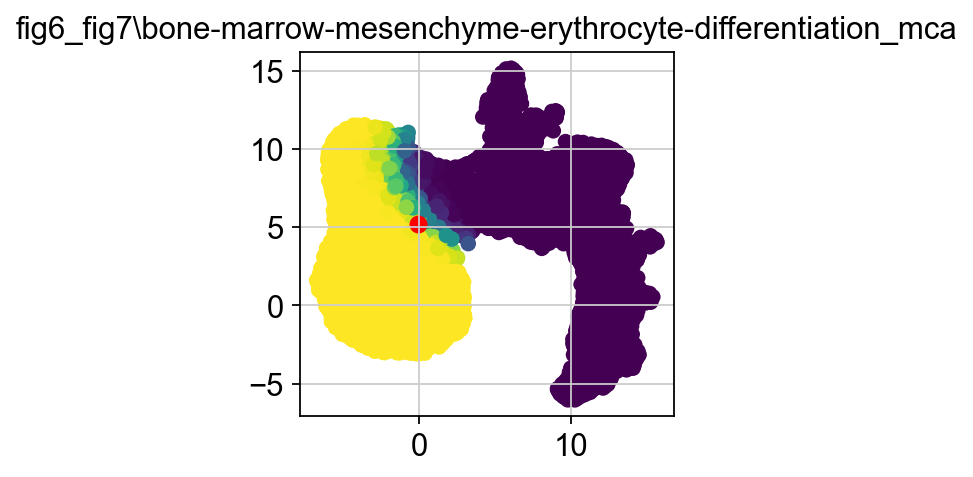

<Figure size 640x640 with 0 Axes>

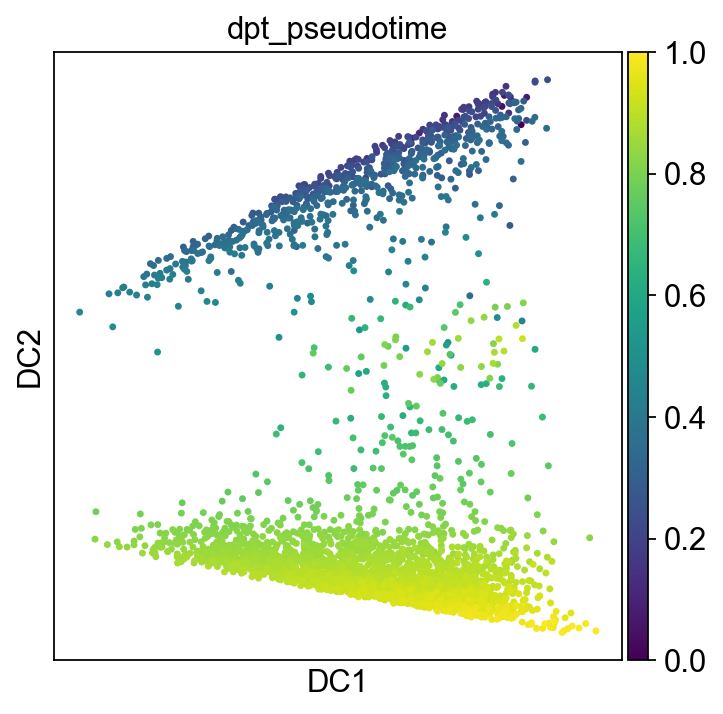

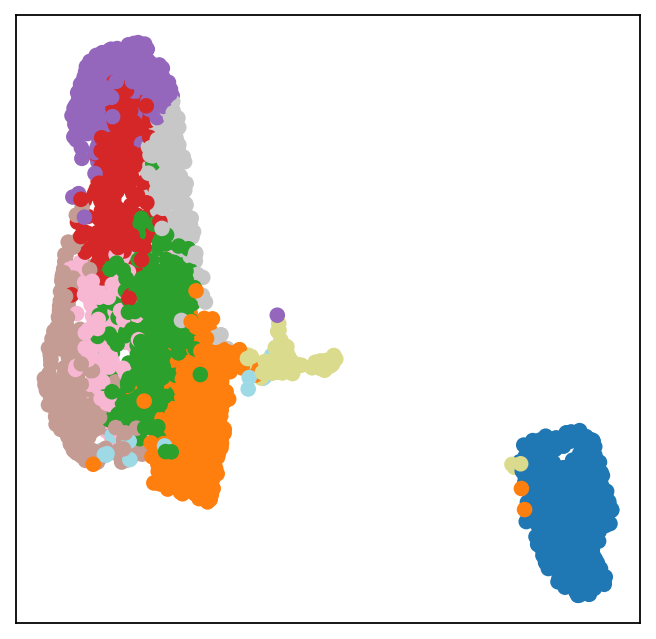

--=-=-=-=--=-=-=-=--=-=-=-=--=-=-=-=--=-=-=-=--=-=-=-=--=-=-=-=--=-=-=-=--=-=-=-=--=


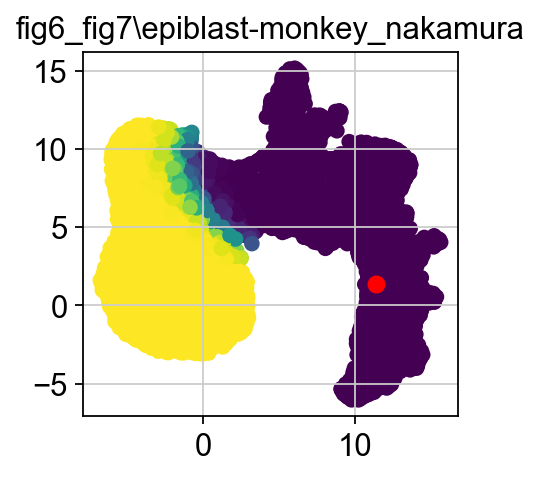

<Figure size 640x640 with 0 Axes>

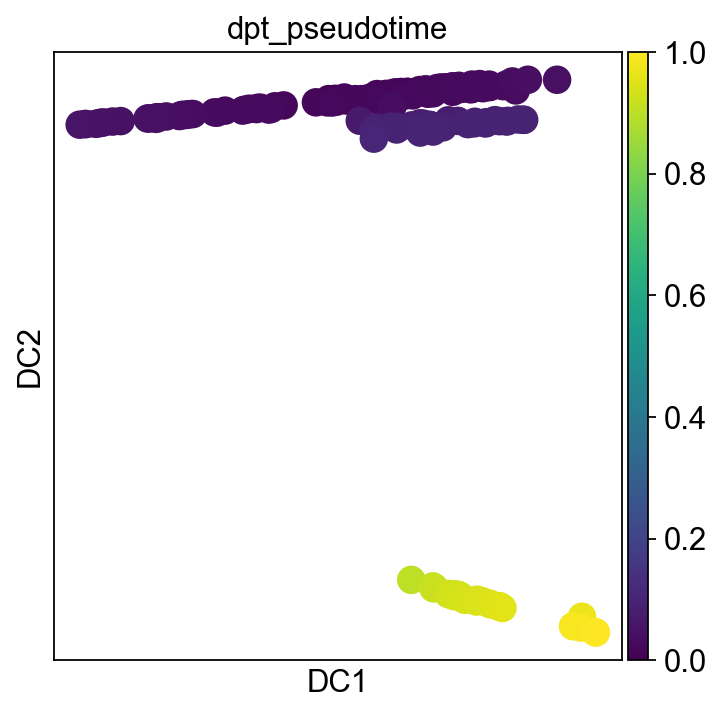

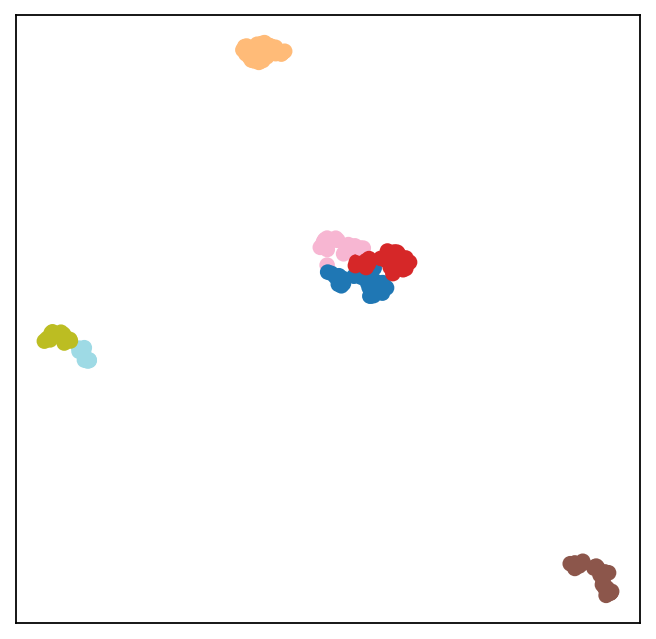

--=-=-=-=--=-=-=-=--=-=-=-=--=-=-=-=--=-=-=-=--=-=-=-=--=-=-=-=--=-=-=-=--=-=-=-=--=


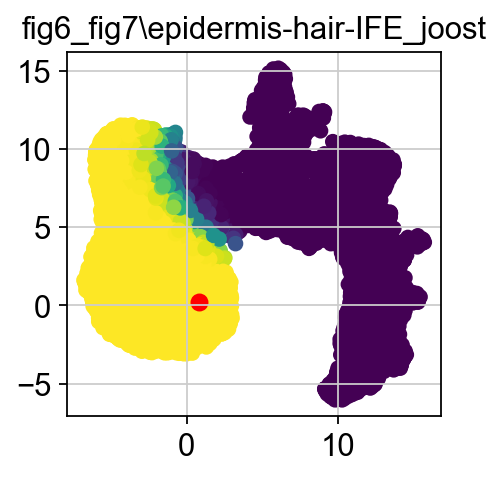

<Figure size 640x640 with 0 Axes>

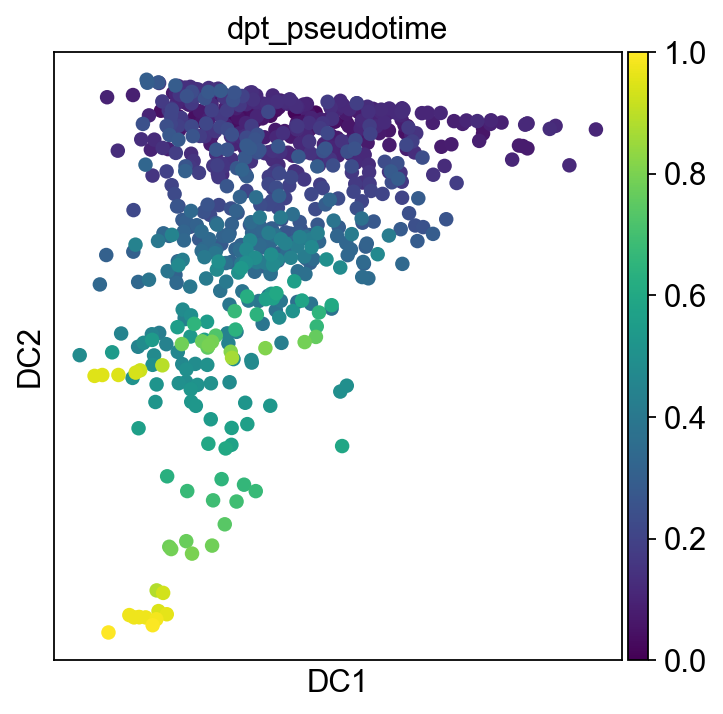

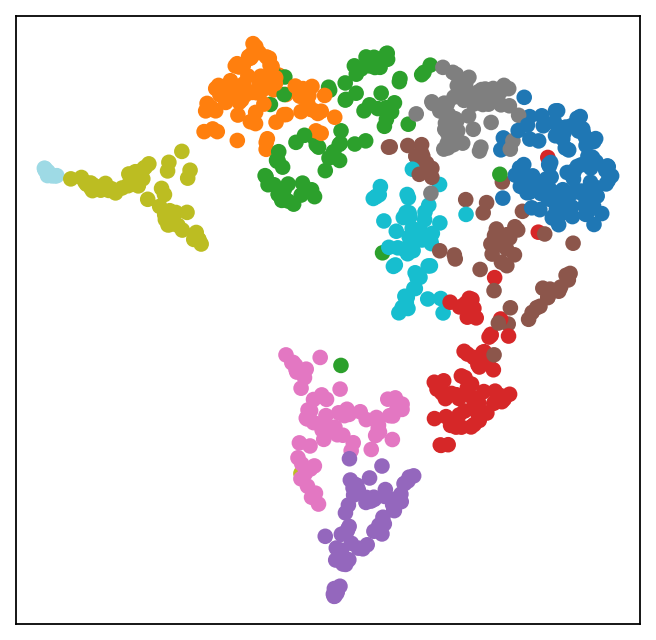

--=-=-=-=--=-=-=-=--=-=-=-=--=-=-=-=--=-=-=-=--=-=-=-=--=-=-=-=--=-=-=-=--=-=-=-=--=


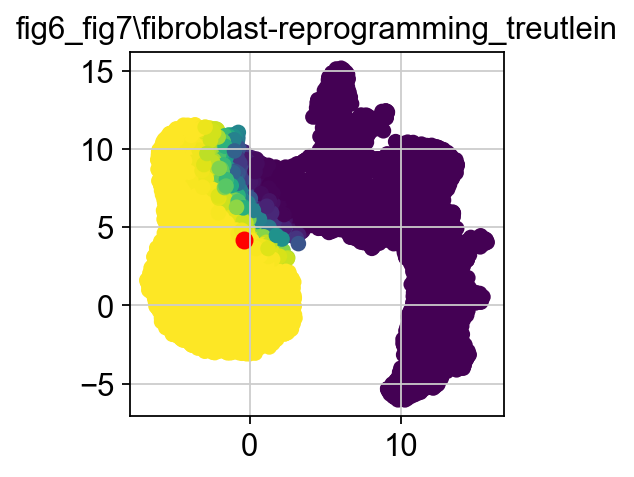

<Figure size 640x640 with 0 Axes>

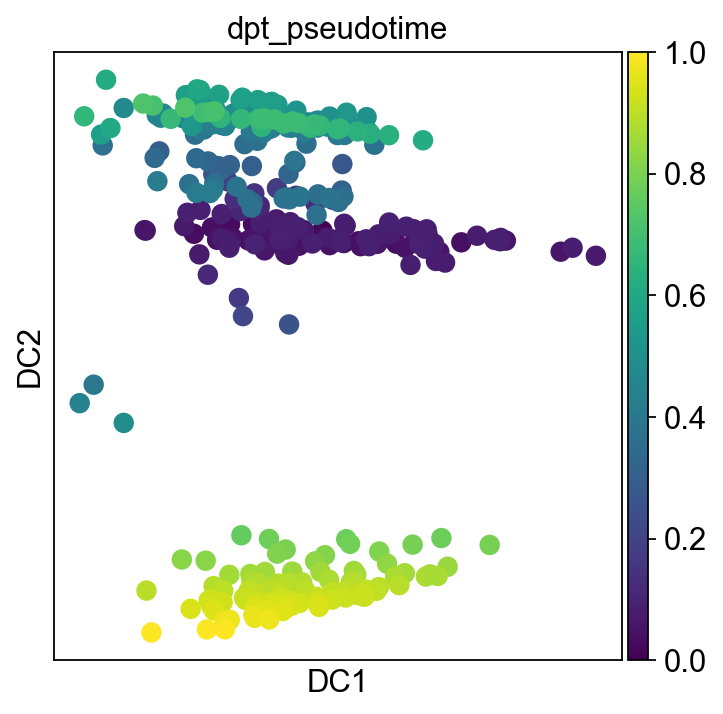

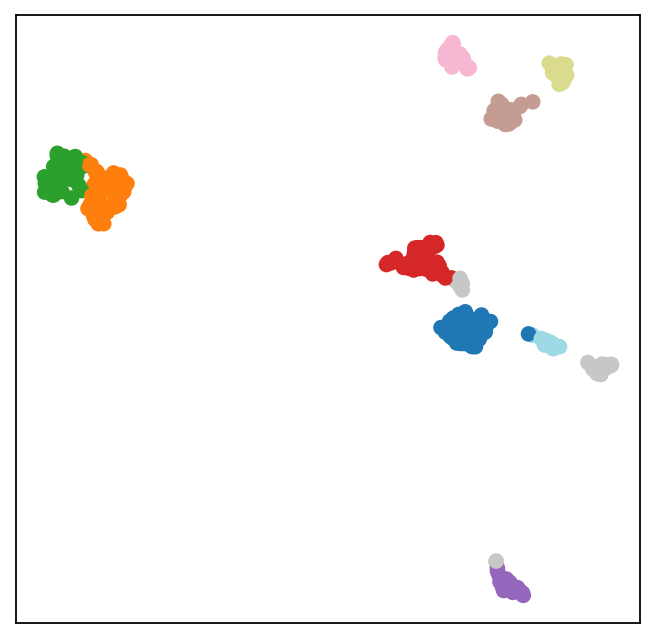

--=-=-=-=--=-=-=-=--=-=-=-=--=-=-=-=--=-=-=-=--=-=-=-=--=-=-=-=--=-=-=-=--=-=-=-=--=


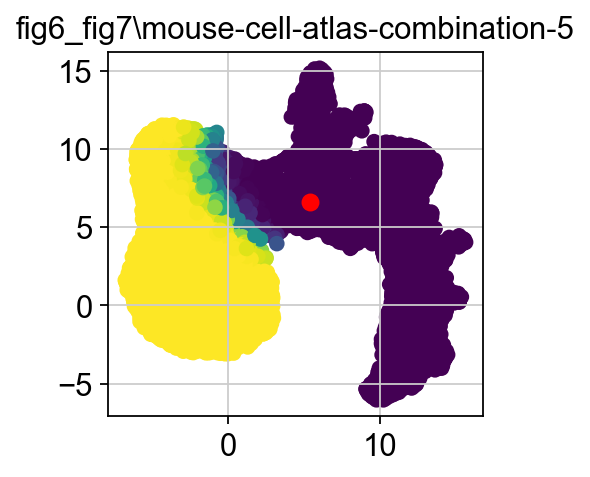

<Figure size 640x640 with 0 Axes>

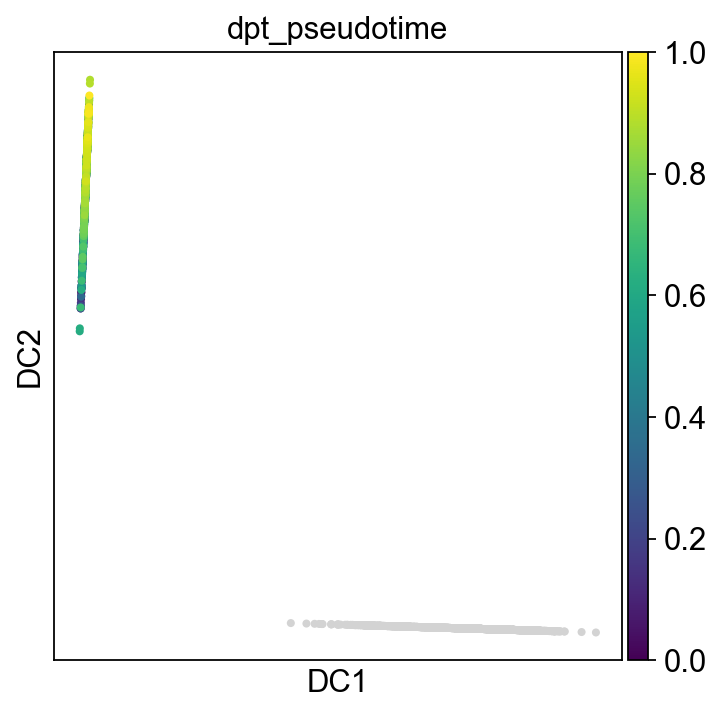

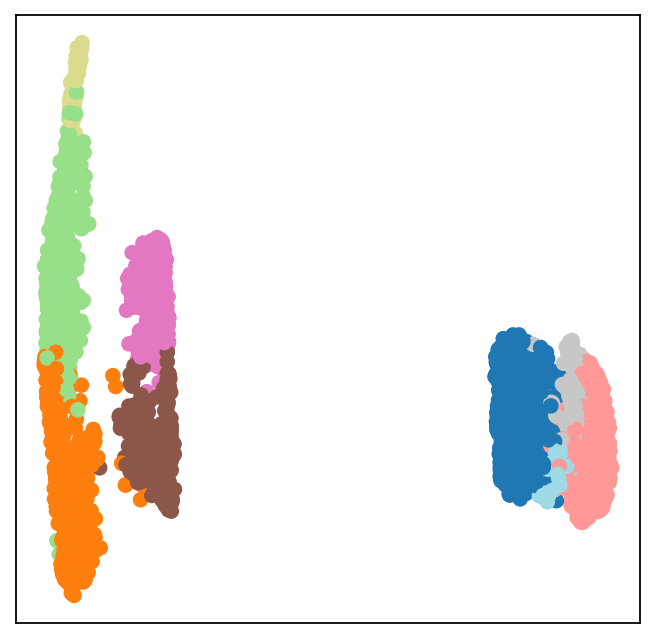

--=-=-=-=--=-=-=-=--=-=-=-=--=-=-=-=--=-=-=-=--=-=-=-=--=-=-=-=--=-=-=-=--=-=-=-=--=


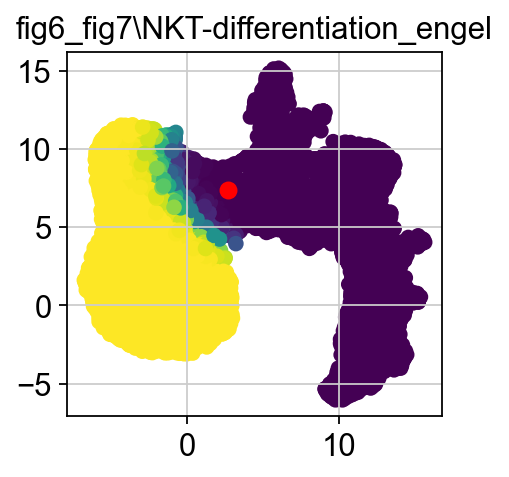

<Figure size 640x640 with 0 Axes>

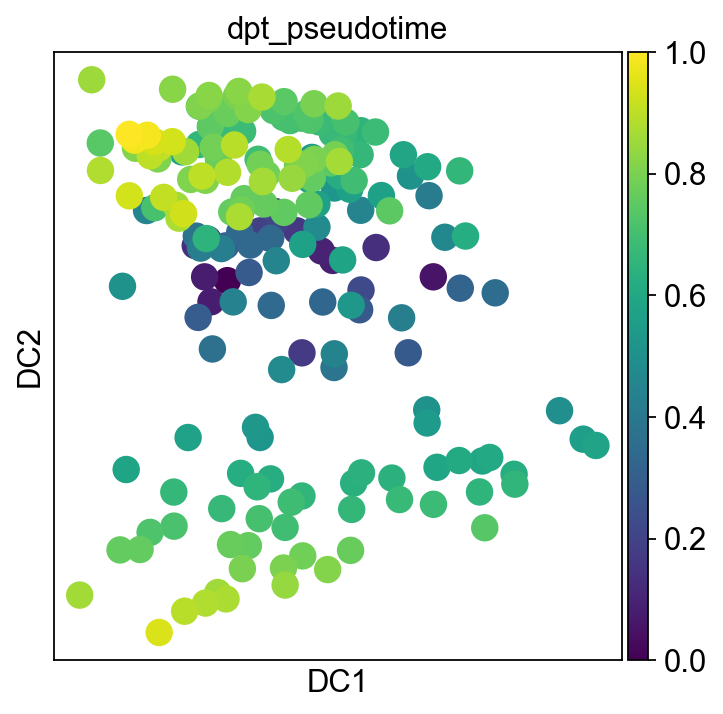

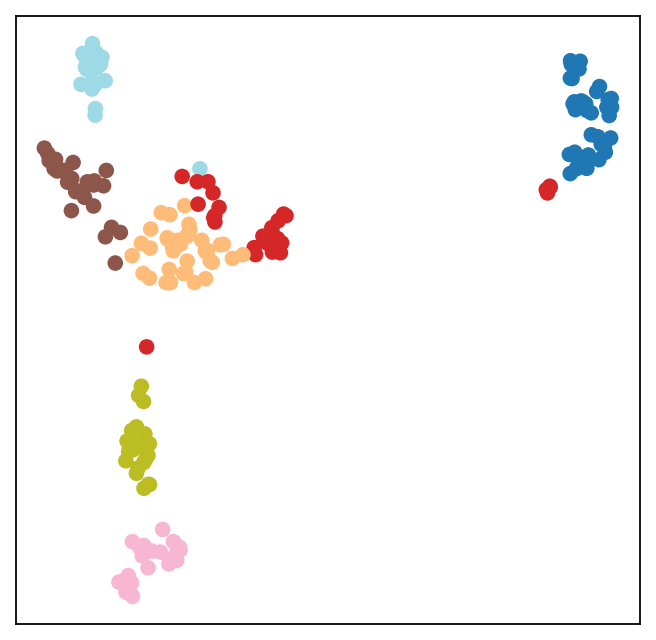

--=-=-=-=--=-=-=-=--=-=-=-=--=-=-=-=--=-=-=-=--=-=-=-=--=-=-=-=--=-=-=-=--=-=-=-=--=


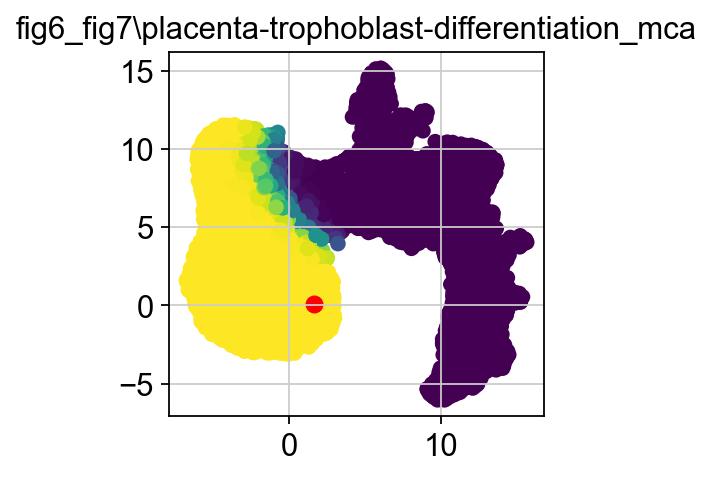

<Figure size 640x640 with 0 Axes>

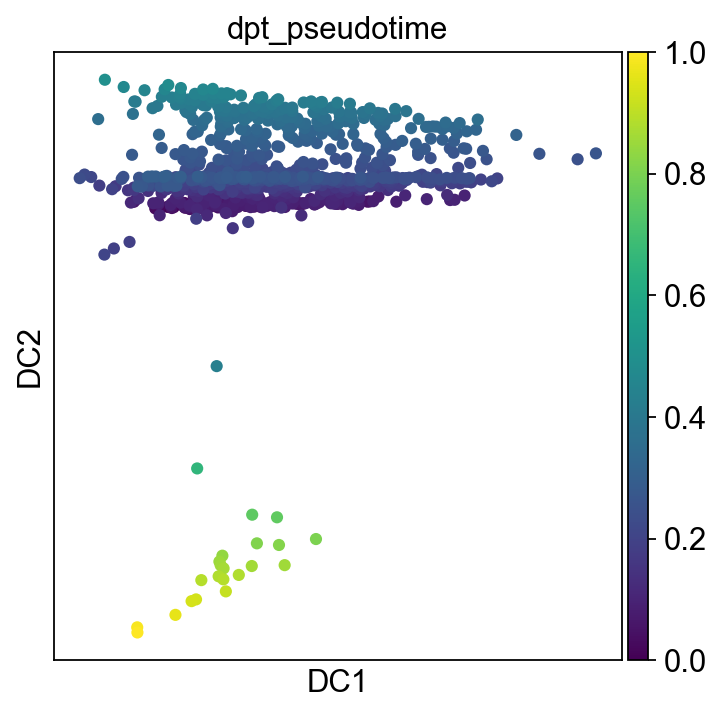

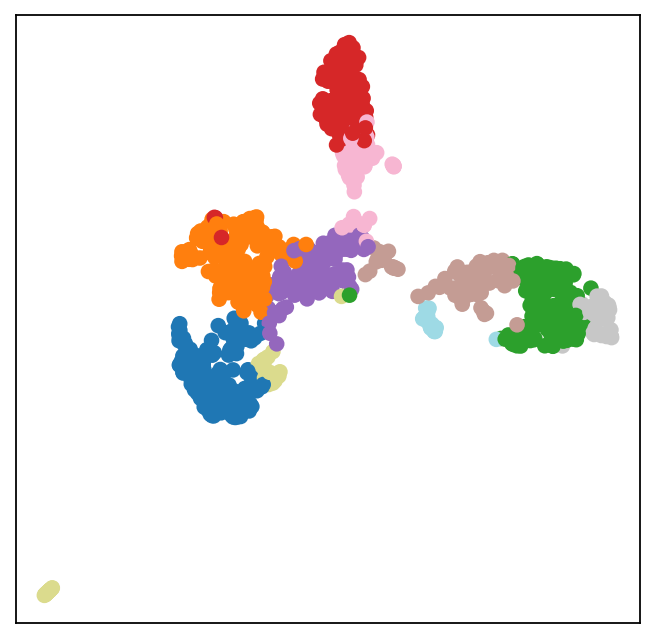

--=-=-=-=--=-=-=-=--=-=-=-=--=-=-=-=--=-=-=-=--=-=-=-=--=-=-=-=--=-=-=-=--=-=-=-=--=


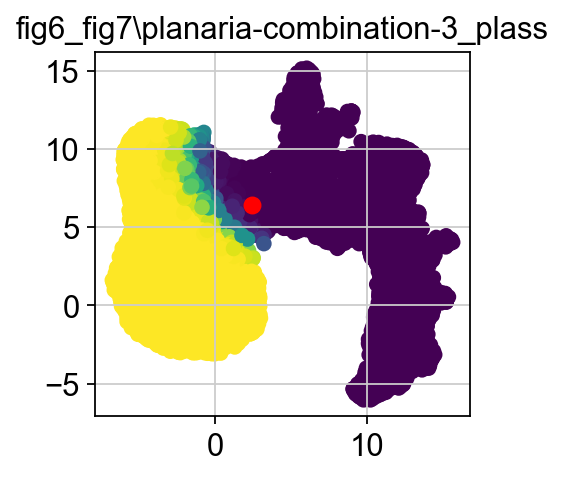

<Figure size 640x640 with 0 Axes>

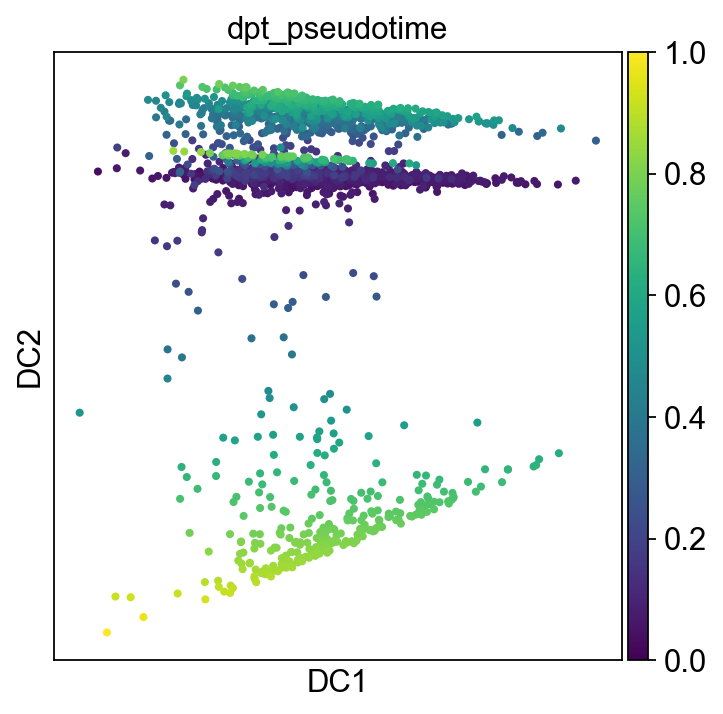

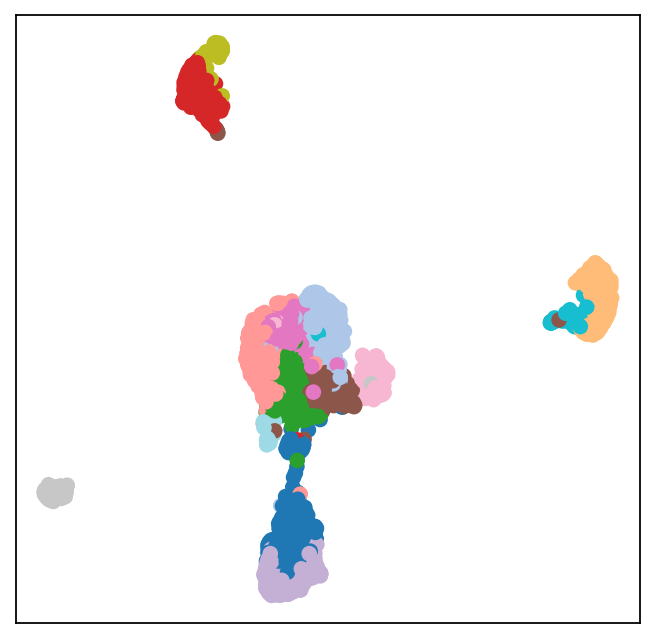

--=-=-=-=--=-=-=-=--=-=-=-=--=-=-=-=--=-=-=-=--=-=-=-=--=-=-=-=--=-=-=-=--=-=-=-=--=


In [86]:
#
for i in range(len(files)):
        plt.figure(figsize=(3,3))
        plt.scatter(embedding[:,0],embedding[:,1], c = p, alpha = 1)
        plt.scatter(np_real_emb_67[i,0],np_real_emb_67[i,1], c = 'r', s = 50)
        plt.title(names[i].split('/')[-1].split('.rds')[0])
        plt.show()

        df = pd.read_csv(files[i], index_col=0)
        df = preprocessing(np.array(df))
        data = np.array(df)
        data = AnnData(data)
        data.uns['iroot'] = 0 
        plt.figure(figsize=(8,8))
        sp.set_figure_params(dpi=80, dpi_save=150, figsize=(5,5))
        sp.tl.pca(data, svd_solver='arpack')
        sp.pp.neighbors(data)
        sp.tl.diffmap(data)
        sp.tl.dpt(data)
        sp.pl.diffmap(data,color=['dpt_pseudotime'])

        pca = PCA(n_components=20)
        embedding_pca = pca.fit_transform(df)
        A = kneighbors_graph(embedding_pca, 10, mode='connectivity', include_self=True)
        louvain = Louvain()
        labels = louvain.fit_transform(A)
        Umap = umap.UMAP()
        embedding_umap = Umap.fit_transform(embedding_pca)
        fig = plt.figure(figsize=(5,5))
        plt.scatter(embedding_umap[:,0],embedding_umap[:,1],c=labels, alpha=1, cmap='tab20')
        plt.xticks([])
        plt.yticks([])
        plt.show()
        print('--=-=-=-=--=-=-=-=--=-=-=-=--=-=-=-=--=-=-=-=--=-=-=-=--=-=-=-=--=-=-=-=--=-=-=-=--=')